## EECE5644 Assignment2 - Question 3

#### Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
np.random.seed(42)

#### Define MAP objective function

In [2]:
def map_objective(pos, landmarks, measurements, sigma_r, sigma_x, sigma_y):
    x, y = pos
    obj = 0
    
    # Likelihood term from range measurements
    for i in range(len(landmarks)):
        dist = np.sqrt((x - landmarks[i][0])**2 + (y - landmarks[i][1])**2)
        obj += (measurements[i] - dist)**2 / (2 * sigma_r**2)
    
    # Prior term
    obj += x**2 / (2 * sigma_x**2) + y**2 / (2 * sigma_y**2)
    
    return obj

#### Set parameters and true vehicle location

In [3]:
# True vehicle location (inside unit circle)
x_true = 0.3
y_true = 0.4
true_pos = np.array([x_true, y_true])

# Measurement noise standard deviation
sigma_r = 0.3

# Prior standard deviations
sigma_x = 0.25
sigma_y = 0.25

# Number of landmarks to test
K_values = [1, 2, 3, 4]

#### Function to generate landmarks and measurements

In [4]:
def generate_landmarks_and_measurements(K, true_pos, sigma_r):
    # Place K landmarks evenly on unit circle
    angles = np.linspace(0, 2*np.pi, K, endpoint=False)
    landmarks = np.column_stack([np.cos(angles), np.sin(angles)])
    
    # Generate range measurements
    measurements = []
    for landmark in landmarks:
        true_dist = np.linalg.norm(true_pos - landmark)
        while True:
            noise = np.random.normal(0, sigma_r)
            measurement = true_dist + noise
            if measurement >= 0:  # Reject negative measurements
                measurements.append(measurement)
                break
    
    return landmarks, np.array(measurements)

#### Create contour plots for each K value

K=1: MAP estimate = [0.018, -0.000], Error = 0.489
K=2: MAP estimate = [0.230, -0.000], Error = 0.406
K=3: MAP estimate = [-0.046, 0.184], Error = 0.408
K=4: MAP estimate = [-0.021, 0.231], Error = 0.363


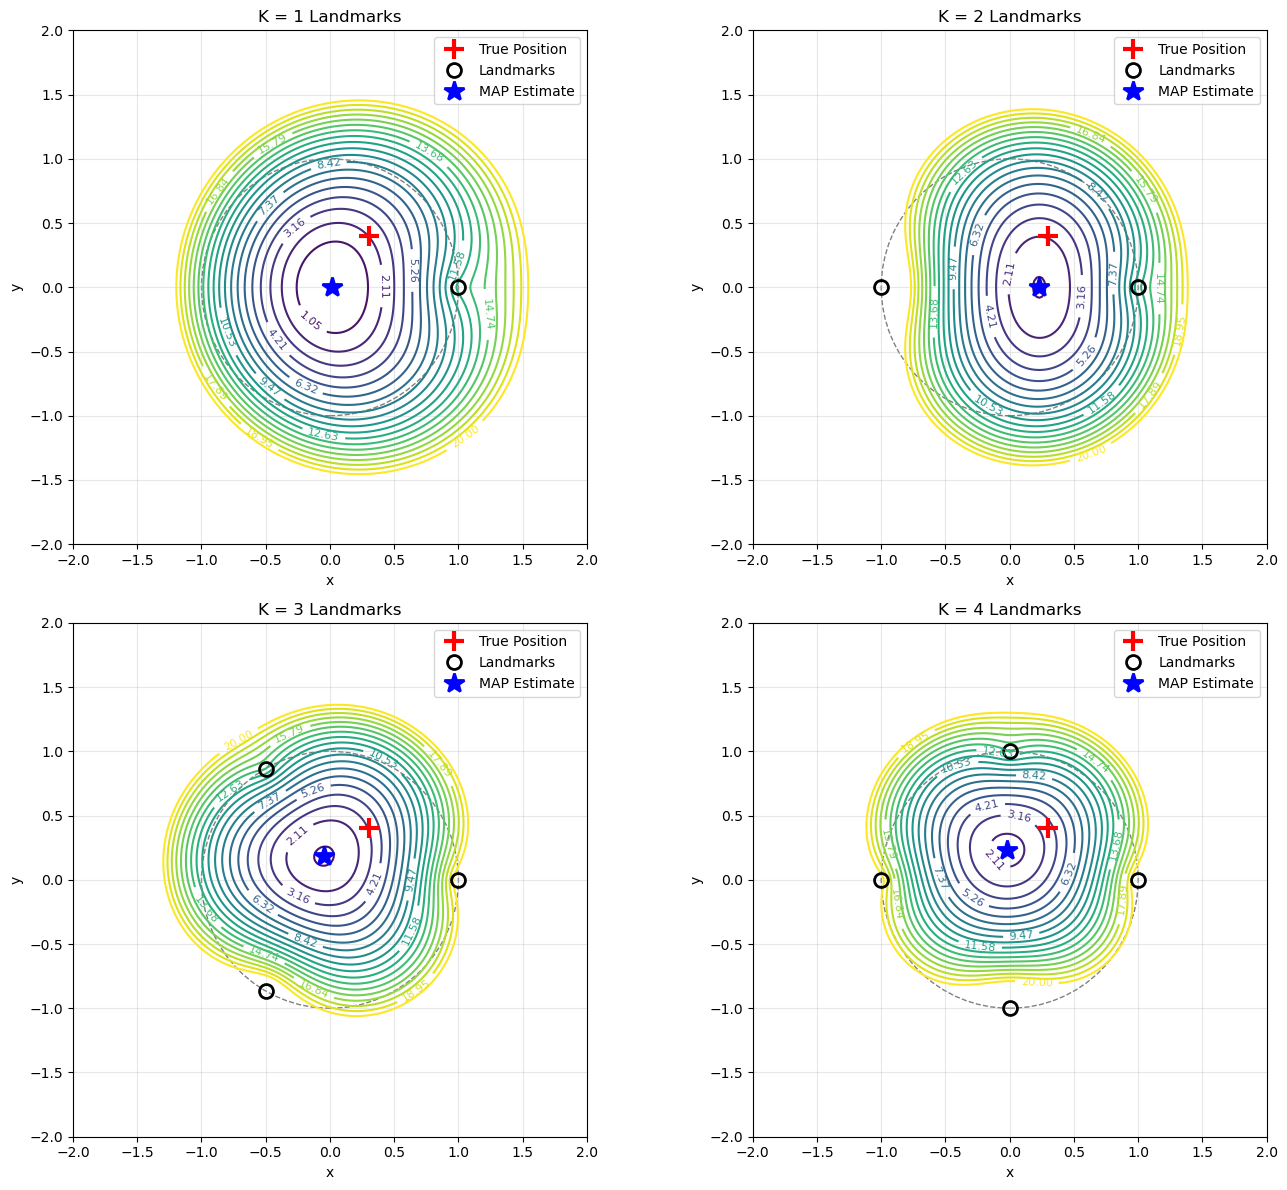

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

# Create grid for contour plots
x_range = np.linspace(-2, 2, 200)
y_range = np.linspace(-2, 2, 200)
X, Y = np.meshgrid(x_range, y_range)

# Common contour levels for comparison
contour_levels = np.linspace(0, 20, 20)

for idx, K in enumerate(K_values):
    # Generate landmarks and measurements
    landmarks, measurements = generate_landmarks_and_measurements(K, true_pos, sigma_r)
    
    # Compute MAP objective over grid
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            pos = np.array([X[i,j], Y[i,j]])
            Z[i,j] = map_objective(pos, landmarks, measurements, sigma_r, sigma_x, sigma_y)
    
    # Find MAP estimate
    result = minimize(map_objective, x0=[0, 0], 
                     args=(landmarks, measurements, sigma_r, sigma_x, sigma_y),
                     method='BFGS')
    map_estimate = result.x
    
    # Plot contours
    ax = axes[idx]
    contour = ax.contour(X, Y, Z, levels=contour_levels, cmap='viridis')
    ax.clabel(contour, inline=True, fontsize=8)
    
    # Plot true location
    ax.plot(x_true, y_true, 'r+', markersize=15, markeredgewidth=3, label='True Position')
    
    # Plot landmarks
    ax.plot(landmarks[:, 0], landmarks[:, 1], 'ko', markersize=10, 
            markerfacecolor='none', markeredgewidth=2, label='Landmarks')
    
    # Plot MAP estimate
    ax.plot(map_estimate[0], map_estimate[1], 'b*', markersize=15, 
            markeredgewidth=2, label='MAP Estimate')
    
    # Plot unit circle
    circle = plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='--', linewidth=1)
    ax.add_patch(circle)
    
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'K = {K} Landmarks')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    # Print MAP estimate error
    error = np.linalg.norm(map_estimate - true_pos)
    print(f"K={K}: MAP estimate = [{map_estimate[0]:.3f}, {map_estimate[1]:.3f}], Error = {error:.3f}")

plt.tight_layout()
plt.show()

#### Analyze MAP estimate behavior with varying K

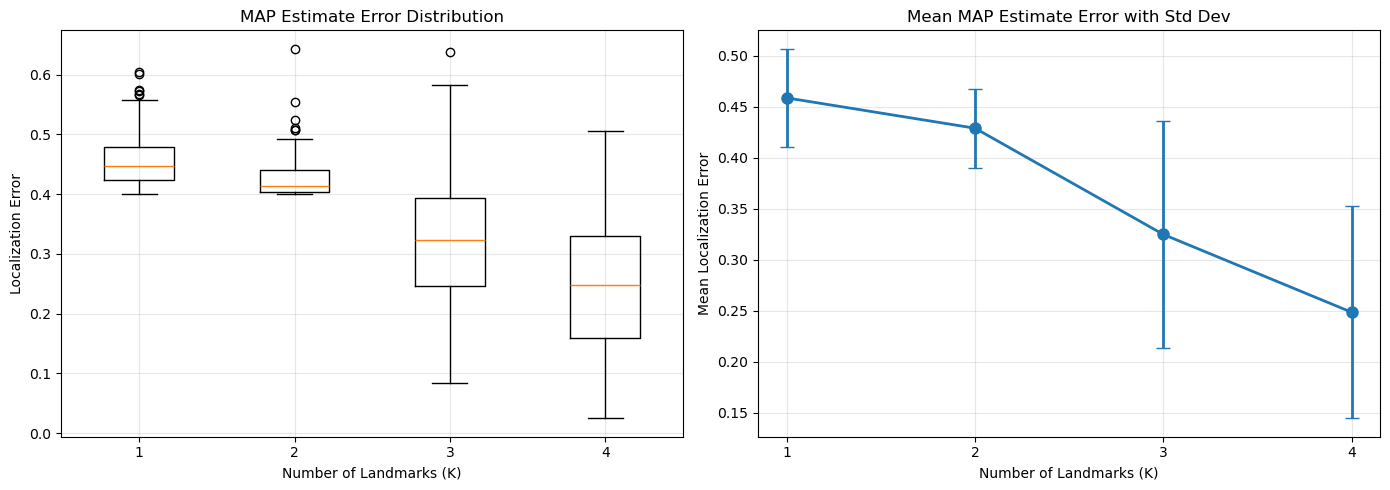


Error Statistics over 100 trials:
K	Mean Error	Std Dev
1	0.4588		0.0481
2	0.4291		0.0388
3	0.3249		0.1115
4	0.2486		0.1039


In [6]:
# Run multiple trials to assess performance
n_trials = 100
errors = {K: [] for K in K_values}

for K in K_values:
    for _ in range(n_trials):
        landmarks, measurements = generate_landmarks_and_measurements(K, true_pos, sigma_r)
        result = minimize(map_objective, x0=[0, 0],
                         args=(landmarks, measurements, sigma_r, sigma_x, sigma_y),
                         method='BFGS')
        map_estimate = result.x
        error = np.linalg.norm(map_estimate - true_pos)
        errors[K].append(error)

# Plot error statistics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Box plot of errors
ax1.boxplot([errors[K] for K in K_values], labels=K_values)
ax1.set_xlabel('Number of Landmarks (K)')
ax1.set_ylabel('Localization Error')
ax1.set_title('MAP Estimate Error Distribution')
ax1.grid(True, alpha=0.3)

# Mean and std of errors
means = [np.mean(errors[K]) for K in K_values]
stds = [np.std(errors[K]) for K in K_values]
ax2.errorbar(K_values, means, yerr=stds, marker='o', capsize=5, linewidth=2, markersize=8)
ax2.set_xlabel('Number of Landmarks (K)')
ax2.set_ylabel('Mean Localization Error')
ax2.set_title('Mean MAP Estimate Error with Std Dev')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(K_values)

plt.tight_layout()
plt.show()

# Print statistics
print("\nError Statistics over", n_trials, "trials:")
print("K\tMean Error\tStd Dev")
for K in K_values:
    print(f"{K}\t{np.mean(errors[K]):.4f}\t\t{np.std(errors[K]):.4f}")